### CNN Model Training

#### Imports

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

#### Load and Split Dataset
80% training, 20% validation

In [3]:
# Load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match the input shape of the CNN
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Create a TensorFlow dataset from a DataFrame
def create_tf_dataset(image_paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
# Load the CSV file
csv_path = '../../data/preprocessed_images/ISIC_2019_2020_Training_Oversampled.csv'
df = pd.read_csv(csv_path)
df = df[df['path'].apply(os.path.exists)].reset_index(drop=True)

# Load image and label paths
image_paths = df['path'].values
labels = df['melanoma'].values.astype('float32')

# Split dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

# Create TensorFlow datasets for training and validation
train_dataset = create_tf_dataset(train_paths, train_labels)
val_dataset = create_tf_dataset(val_paths, val_labels)

print("Dataset loaded and preprocessed.")

Training set size: 53360
Validation set size: 13341
Dataset loaded and preprocessed.


#### Preview Dataset

Previewing training dataset:


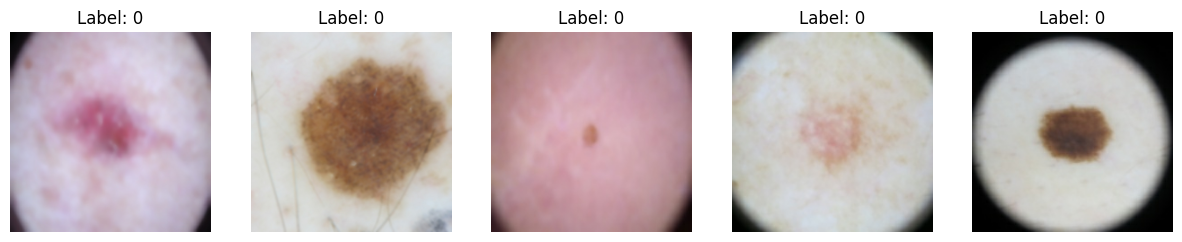

2025-05-25 21:30:09.505098: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Previewing validation dataset:


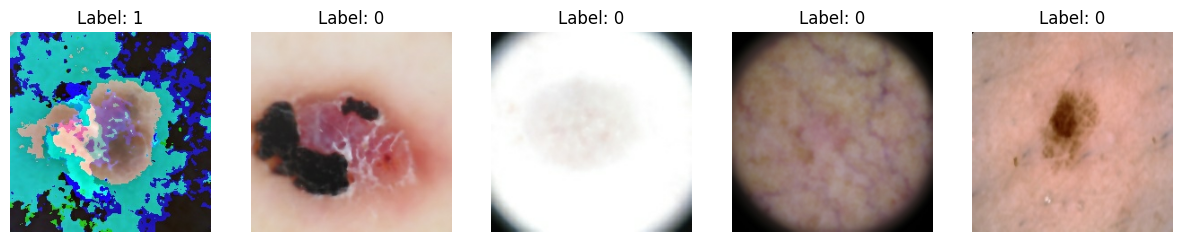

2025-05-25 21:30:10.967200: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Preview a batch of images and labels
def preview_dataset(dataset, num_images=5):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(15, 15))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {int(labels[i].numpy())}")
            plt.axis("off")
        plt.show()

# Preview the training dataset
print("Previewing training dataset:")
preview_dataset(train_dataset)

# Preview the validation dataset
print("Previewing validation dataset:")
preview_dataset(val_dataset)

#### Build the CNN Model

In [5]:
# function for focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# build the cnn model from scratch 
def build_cnn_model():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # compile the model
    model.compile(optimizer='adam',
                loss=focal_loss(alpha=0.25, gamma=2.0),
                metrics=['accuracy'])
    
    return model

# actually build the model
model = build_cnn_model()
# show model architecture
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,886,593 (7.20 MB)

 Trainable params: 1,885,249 (7.19 MB)

 Non-trainable params: 1,344 (5.25 KB)

#### Train the Model

In [6]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=10,         # wait for 10 epochs for improvement
    restore_best_weights=True,  # restore the best weights when training stops
    verbose=1
)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',  # file where the model will be saved
    monitor='val_loss',  # monitor validation loss
    save_best_only=True,  # save the model only if the validation loss improves
    verbose=1
)

epochs = 25  
batch_size = 16

# Train the model with early stopping and model checkpoint
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7840 - loss: 0.0387
Epoch 1: val_loss improved from inf to 0.04305, saving model to best_model.keras
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 4991s 3s/step - accuracy: 0.7840 - loss: 0.0387 - val_accuracy: 0.8008 - val_loss: 0.0431
Epoch 2/25
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8276 - loss: 0.0247
Epoch 2: val_loss improved from 0.04305 to 0.02180, saving model to best_model.keras
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3433s 2s/step - accuracy: 0.8276 - loss: 0.0247 - val_accuracy: 0.8561 - val_loss: 0.0218
Epoch 3/25
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8481 - loss: 0.0228
Epoch 3: val_loss improved from 0.02180 to 0.02094, saving model to best_model.keras
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 3398s 2s/step - accuracy: 0.8481 - loss: 0.0228 - val_accuracy: 0.8590 - val_loss: 0.0209
Epoch 4/25
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8500 - loss: 0.0223
Epoch 4: val_loss did not improve from

#### Evaluate the Model
Binary Cross Entropy Loss

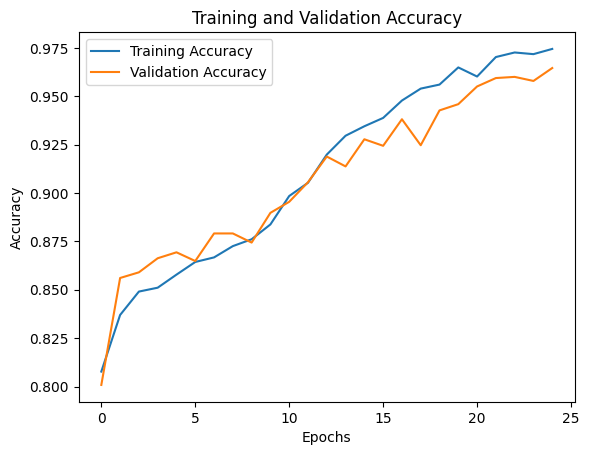

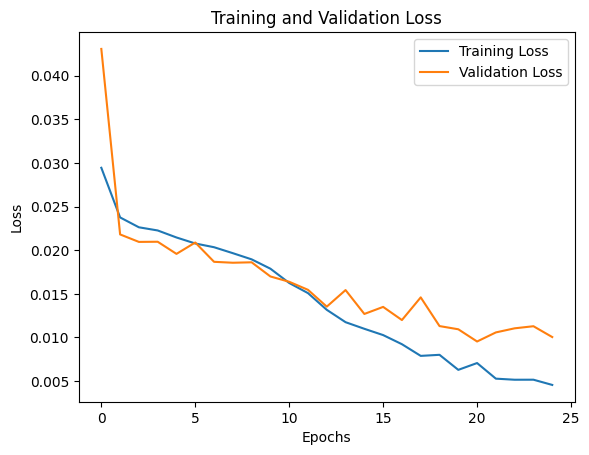

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()